# Comparison of exact and optimized DMD for a simple 1D example

In [6]:
from os import makedirs
from os.path import join
from math import sqrt
from time import time
from collections import defaultdict
import warnings
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from pydmd import BOPDMD
from flowtorch.analysis import DMD, OptDMD, HOOptDMD, SVD
from notebook_utils import set_seed

results_path = join("results", "1d_example")
makedirs(results_path, exist_ok=True)
plt.rcParams["figure.dpi"] = 160
plt.rcParams["text.usetex"] = True
pt.set_default_dtype(pt.float64)
warnings.filterwarnings("ignore")

## Test data

We use the same test function as in example 2 of [T. Askham and J. N. Kutz](https://epubs.siam.org/doi/10.1137/M1124176):
$$
    z(x, t) = \mathrm{sin}(k_1 x-\omega_1 t)e^{\gamma_1 t} + \mathrm{sin}(k_2 x-\omega_2 t)e^{\gamma_2 t} + \sigma g,
$$
where the free parameters are set to $k_1 = 1$, $\omega_1 = 1$, $\gamma_1 = 1$, $k_2=0.4$, $\omega_2 = 3.7$, and $\gamma_2 = -0.2$. $g$ is a random sample drawn from a Gaussian distribution with zero mean and unit standard deviation. $\sigma$ controls the intensity of the added noise.

In [7]:
x = pt.linspace(0, 15, 300)
t = pt.linspace(0.0, 2*np.pi, 2**9)
xx, tt = pt.meshgrid(x, t, indexing="ij")
x.shape, t.shape, xx.shape, tt.shape

(torch.Size([300]),
 torch.Size([512]),
 torch.Size([300, 512]),
 torch.Size([300, 512]))

In [8]:
def signal(x, t, k, omega, gamma):
    return pt.sin(k*x - omega*t)*pt.exp(gamma*t)

def test_function(x, t, k_1=1.0, omega_1=1.0, gamma_1=1.0, k_2=0.4, omega_2=3.7, gamma_2=-0.2, sigma_sqr=0.0):
    noise = sqrt(sigma_sqr) * pt.normal(pt.zeros_like(x), pt.ones_like(x))
    return signal(x, t, k_1, omega_1, gamma_1) + signal(x, t, k_2, omega_2, gamma_2) + noise

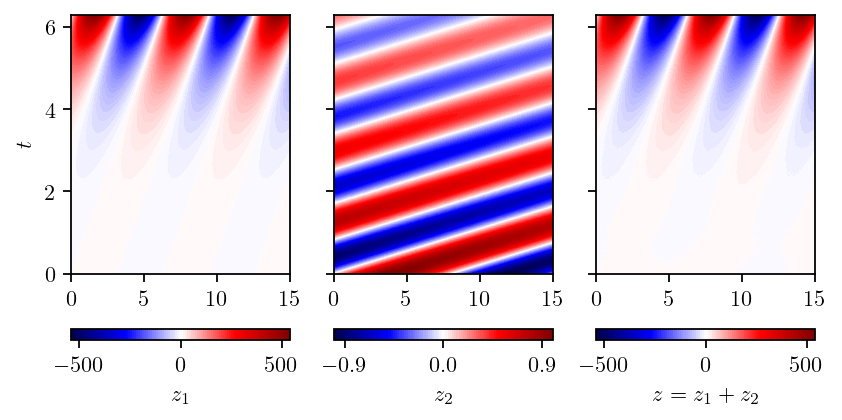

In [9]:
fig, axarr = plt.subplots(1, 3, figsize=(6, 3), sharex=True, sharey=True)
cont_0 = axarr[0].contourf(xx, tt, signal(xx, tt, 1.0, 1.0, 1.0), cmap="seismic", levels=120)
cont_1 = axarr[1].contourf(xx, tt, signal(xx, tt, 0.4, 3.7, -0.2), cmap="seismic", levels=120)
cont_2 = axarr[2].contourf(xx, tt, test_function(xx, tt, sigma_sqr=2**-2), cmap="seismic", levels=120)
plt.colorbar(cont_0, ax=axarr[0], label=r"$z_1$", location="bottom", ticks=[-500, 0, 500])
plt.colorbar(cont_1, ax=axarr[1], label=r"$z_2$", location="bottom", ticks=[-0.9, 0, 0.9])
plt.colorbar(cont_2, ax=axarr[2], label=r"$z = z_1 + z_2$", location="bottom", ticks=[-500, 0, 500])
axarr[0].set_ylabel(r"$t$")
plt.show()

In [10]:
noise_exp = (1, 2, 4, 8)
for exp in noise_exp:
    dm = test_function(xx, tt, sigma_sqr=0)
    svd = SVD(dm, rank=4)
    dmr = svd.U.T @ dm
    sigma_sqr = 2**-exp
    snr_512 = dm.square().mean() / sigma_sqr
    snr_256 = dm[:, :256].square().mean() / sigma_sqr
    snr_128 = dm[:, :128].square().mean() / sigma_sqr
    snr_r = dmr.square().mean() / sigma_sqr
    print(snr_128.item(), snr_256.item(), snr_512.item(), snr_r.item())

7.251523814261448 87.31849422573984 23716.449874035712 1778733.7405526782
14.503047628522896 174.63698845147968 47432.899748071424 3557467.4811053565
58.012190514091586 698.5479538059187 189731.5989922857 14229869.924421426
928.1950482254654 11176.7672608947 3035705.583876571 227677918.7907428


## Learning rate fine tuning

In [11]:
dm_ref = test_function(xx, tt, sigma_sqr=0.0)
dt = 2*np.pi/(2**9-1)
dm_range = dm_ref.max() - dm_ref.min()
norm_ref = (dm_ref / dm_range).norm()

In [12]:
noise_exp = (1, 2, 4, 8)

In [7]:
lr_opt = {}
lr_opt_pro = {}
set_seed(0)
for exp in noise_exp:
    dm = test_function(xx, tt, sigma_sqr=2**-exp) / dm_range
    best, best_pro = float("inf"), float("inf")
    for lr in (1e-4, 5e-5, 1e-5, 5e-6, 1e-6):
        dmd = OptDMD(dm, dt, rank=4)
        dmd.train(train_size=1.0, val_size=0.0, loss_key="train_loss", lr=lr, stopping_options={"patience" : 80, "min_delta" : 5e-6})
        norm = (dm_ref[:, :-1]/dm_range - dmd.reconstruction).norm()
        if norm < best:
            best = norm
            lr_opt[exp] = lr
        dmd = HOOptDMD(dm, dt, rank_dr=4, rank=4, delay=1)
        dmd.train(train_size=1.0, val_size=0.0, loss_key="train_loss", lr=lr, stopping_options={"patience" : 80, "min_delta" : 5e-6})
        norm = (dm_ref[:, :-1]/dm_range - dmd.reconstruction).norm()
        if norm < best_pro:
            best_pro = norm
            lr_opt_pro[exp] = lr

Epoch  434 - train loss: 6.393163e-05, val loss: 0.000000e+00, lr: 1.000000e-06

In [8]:
lr_opt

{1: 5e-05, 2: 0.0001, 4: 5e-05, 8: 5e-06}

In [9]:
lr_opt_pro

{1: 5e-05, 2: 0.0001, 4: 1e-05, 8: 1e-05}

In [10]:
logs = {}
set_seed(0)
for exp in noise_exp:
    dm = test_function(xx, tt, sigma_sqr=2**-exp) / dm_range
    dmd = OptDMD(dm, dt, rank=4)
    dmd.train(train_size=1.0, val_size=0.0, loss_key="train_loss", lr=lr_opt[exp], stopping_options={"patience" : 80, "min_delta" : 5e-6})
    logs[f"{exp}"] = dmd.log["train_loss"]
    dmd = HOOptDMD(dm, dt, rank_dr=4, rank=4, delay=1)
    dmd.train(train_size=1.0, val_size=0.0, loss_key="train_loss", lr=lr_opt_pro[exp], stopping_options={"patience" : 80, "min_delta" : 5e-6})
    logs[f"{exp}_pro"] = dmd.log["train_loss"]

Epoch  252 - train loss: 6.042087e-05, val loss: 0.000000e+00, lr: 1.250000e-06

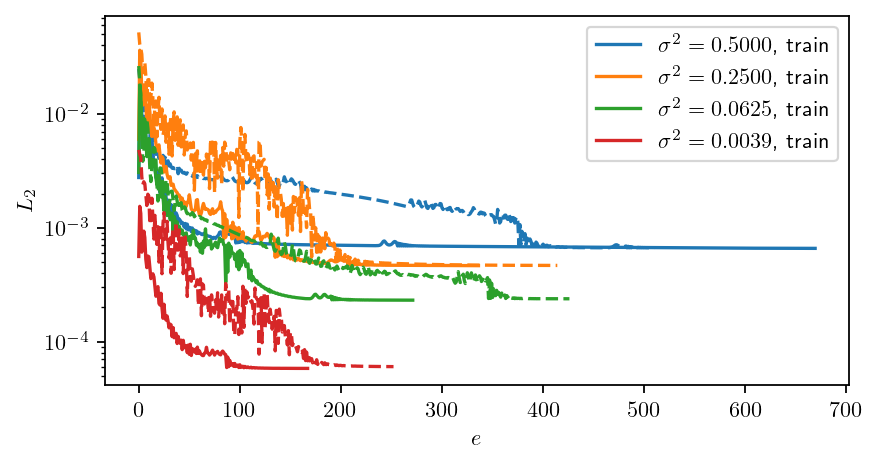

In [11]:
fig, ax = plt.subplots(figsize=(6, 3))
for i, exp in enumerate(noise_exp):
    loss = logs[f"{exp}"]
    e = list(range(len(loss)))
    ax.plot(e, loss, c=f"C{i}", ls="-", label=r"$\sigma^2 = {:1.4f}$, train".format(2**-exp))
    loss = logs[f"{exp}_pro"]
    e = list(range(len(loss)))
    ax.plot(e, loss, c=f"C{i}", ls="--")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$e$")
ax.set_ylabel(r"$L_2$")
plt.show()

## Influence of noise level and number of snapshots

In [13]:
eigs_true = pt.tensor(
    [1.0+1.0j, 1.0-1.0j, -0.2+3.7j, -0.2-3.7j], dtype=pt.complex128
)

def sort_by_real(eigs):
    sorting = eigs.real.sort(descending=True).indices
    return eigs[sorting]

def run_experiment(results, n_snap, exp):
    # create test data
    dm = test_function(xx[:, :n_snap], tt[:, :n_snap], sigma_sqr=2**-exp) / dm_range
    
    # exact DMD with optimal amplitudes
    start = time()
    dmd = DMD(dm, dt, rank=4, optimal=True)
    results["time_exact"].append(time() - start)
    results["eigs_exact"].append(dmd.eigvals_cont)
    results["eigs_err_exact"].append((sort_by_real(dmd.eigvals_cont).abs()-eigs_true.abs()).norm())
    rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_ref.size(1)) * dmd.amplitude.unsqueeze(-1))
    results["err_exact"].append((dm_ref/dm_range - rec).norm() / norm_ref)
    
    # optimized DMD - variable projection
    start = time()
    dmd = BOPDMD(svd_rank=4, num_trials=0, init_alpha=dmd.eigvals_cont.numpy(), eig_constraints={"conjugate_pairs"}, varpro_opts_dict={"verbose": False, "use_fulljac" : True})
    dmd.fit(dm.numpy(), t[:n_snap].numpy())
    results["time_bopt"].append(time() - start)
    results["eigs_err_bopt"].append((sort_by_real(pt.from_numpy(dmd.eigs)).abs()-eigs_true.abs()).norm())
    eigvals = pt.exp(pt.from_numpy(dmd.eigs)*dt)
    rec = pt.from_numpy(dmd.modes) @ (pt.linalg.vander(eigvals, N=dm_ref.size(1)) * pt.from_numpy(dmd.amplitudes).unsqueeze(-1))
    results["err_bopt"].append((dm_ref/dm_range - rec).norm() / norm_ref)
    
    # optimized DMD - backprop. + gradient descent
    lr_opt = {1 : 5e-5, 2 : 5e-5, 4 : 1e-5, 8 : 1e-5}
    start = time()
    dmd = OptDMD(dm, dt, rank=4)
    dmd.train(train_size=1.0, val_size=0.0, loss_key="train_loss", lr=lr_opt[exp],
              stopping_options={"patience" : 80, "min_delta" : 5e-6})
    results["time_opt"].append(time() - start)
    results["eigs_opt"].append(dmd.eigvals_cont)
    results["eigs_err_opt"].append((sort_by_real(dmd.eigvals_cont).abs()-eigs_true.abs()).norm())
    rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_ref.size(1)) * dmd.amplitude.unsqueeze(-1))
    results["err_opt"].append((dm_ref/dm_range - rec).norm() / norm_ref)
    
    # optimized DMD based on POD coefficients - backprop. + gradient descent
    lr_opt_pro = {1 : 5e-5, 2 : 5e-5, 4 : 5e-5, 8 : 5e-5}
    start = time()
    dmd = HOOptDMD(dm, dt, rank_dr=4, rank=4, delay=1)
    dmd.train(train_size=1.0, val_size=0.0, loss_key="train_loss", lr=lr_opt_pro[exp],
              stopping_options={"patience" : 80, "min_delta" : 5e-6})
    results["time_optPro"].append(time() - start)
    results["eigs_optPro"].append(dmd.eigvals_cont)
    results["eigs_err_optPro"].append((sort_by_real(dmd.eigvals_cont).abs()-eigs_true.abs()).norm())
    rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_ref.size(1)) * dmd.amplitude.unsqueeze(-1))
    results["err_optPro"].append((dm_ref/dm_range - rec).norm() / norm_ref)
    

def repeat_experiment(n_trials, n_snap, exp):
    results = defaultdict(list)
    for _ in range(n_trials):
        run_experiment(results, n_snap, exp)
    return results

In [13]:
set_seed(0)
results = {}
for exp in (1, 2, 4, 8):
    for m in (128, 256, 512):
        start = time()
        results[f"{exp}_{m}"] = repeat_experiment(100, m, exp)
        diff = time() - start
        print(f"\nFinished parameter set exp={exp}, m={m} in {diff:1.2f}s")
pt.save(results, join(results_path, "parameter_study.pt"))

Epoch  757 - train loss: 6.878201e-04, val loss: 0.000000e+00, lr: 5.000000e-05
Finished parameter set exp=1, m=128 in 725.34s
Epoch  315 - train loss: 6.624011e-04, val loss: 0.000000e+00, lr: 2.500000e-05
Finished parameter set exp=1, m=256 in 862.17s
Epoch  424 - train loss: 6.697263e-04, val loss: 0.000000e+00, lr: 1.250000e-05
Finished parameter set exp=1, m=512 in 2951.10s
Epoch  534 - train loss: 4.652718e-04, val loss: 0.000000e+00, lr: 5.000000e-05
Finished parameter set exp=2, m=128 in 450.11s
Epoch  226 - train loss: 4.745274e-04, val loss: 0.000000e+00, lr: 1.250000e-05
Finished parameter set exp=2, m=256 in 591.54s
Epoch  391 - train loss: 4.631972e-04, val loss: 0.000000e+00, lr: 6.250000e-06
Finished parameter set exp=2, m=512 in 1772.57s
Epoch  243 - train loss: 2.305488e-04, val loss: 0.000000e+00, lr: 5.000000e-05
Finished parameter set exp=4, m=128 in 241.69s
Epoch  166 - train loss: 2.339695e-04, val loss: 0.000000e+00, lr: 1.250000e-05
Finished parameter set exp=4,

In [14]:
results = pt.load(join(results_path, "parameter_study.pt"))

In [15]:
def extract_statistics(results, exp, key):
    n_snap = []
    mean, ci, emin, emax = [], [], [], []
    for m in (128, 256, 512):
        n_snap.append(m)
        if not "err" in key and not "time" in key:
            data = pt.vstack(results[f"{exp}_{m}"][key]).T
        else:
            data = pt.tensor(results[f"{exp}_{m}"][key])
        mean.append(data.mean(-1))
        ci.append(1.96*data.std(-1)/sqrt(data.size(-1)))
        emin.append(data.min())
        emax.append(data.max())
        
    return n_snap, mean, ci, emin, emax

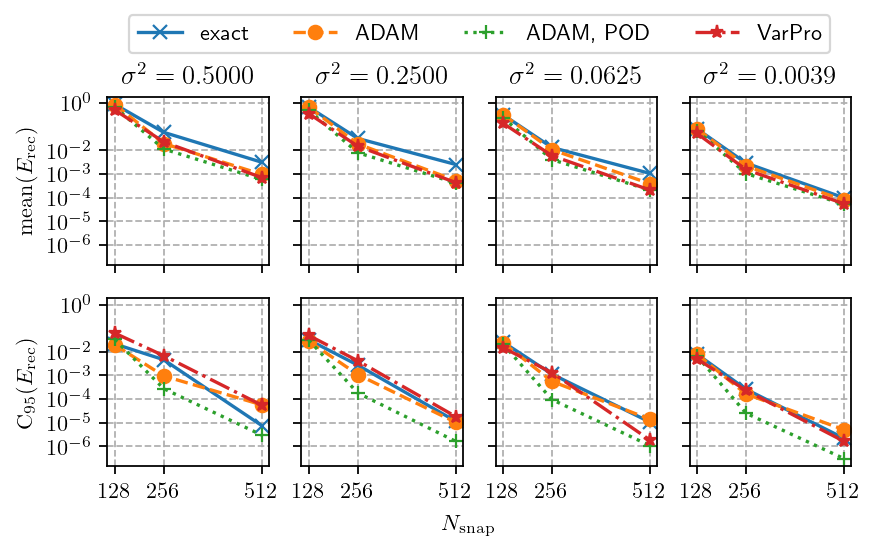

In [16]:
fig, axarr = plt.subplots(2, 4, figsize=(6, 3), sharex=True, sharey=True)

for i, exp in enumerate((1, 2, 4, 8)):
    n_snap, mean, ci, emin, emax = extract_statistics(results, exp, "err_exact")
    # axarr[0, i].fill_between(n_snap, emin, emax, alpha=0.3)
    axarr[0, i].plot(n_snap, mean, ls="-", label="exact", marker="x")
    axarr[1, i].plot(n_snap, ci, ls="-", label="exact", marker="x")
    n_snap, mean, ci, emin, emax = extract_statistics(results, exp, "err_opt")
    # axarr[0, i].fill_between(n_snap, emin, emax, alpha=0.3, color="C1")
    axarr[0, i].plot(n_snap, mean, ls="--", label="ADAM", marker="o")
    axarr[1, i].plot(n_snap, ci, ls="--", label="ADAM", marker="o")
    n_snap, mean, ci, emin, emax = extract_statistics(results, exp, "err_optPro")
    # axarr[0, i].fill_between(n_snap, emin, emax, alpha=0.3, color="C2")
    axarr[0, i].plot(n_snap, mean, ls=":", label="ADAM, POD", marker="+")
    axarr[1, i].plot(n_snap, ci, ls=":", label="ADAM, POD", marker="+")
    n_snap, mean, ci, emin, emax = extract_statistics(results, exp, "err_bopt")
    # axarr[0, i].fill_between(n_snap, emin, emax, alpha=0.3, color="C3")
    axarr[0, i].plot(n_snap, mean, ls="-.", label="VarPro", marker="*")
    axarr[1, i].plot(n_snap, ci, ls="-.", label="VarPro", marker="*")
    axarr[0, i].set_title(r"$\sigma^2 = {:1.4f}$".format(2**-exp))
for ax in axarr.flatten():
    ax.set_yscale("log")
    ax.set_xticks(n_snap)
    ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1])
    ax.grid(ls="--")
axarr[0, 0].legend(ncol=4, bbox_to_anchor=(2.3, 1.55), loc="upper center")
axarr[0, 0].set_ylabel(r"$\mathrm{mean}(E_\mathrm{rec})$")
axarr[1, 0].set_ylabel(r"$\mathrm{C}_{95}(E_\mathrm{rec})$")
fig.text(0.5, -0.02, r"$N_{\mathrm{snap}}$", ha="center")
plt.savefig(join(results_path, "reconstruction_error.pdf"), bbox_inches="tight")

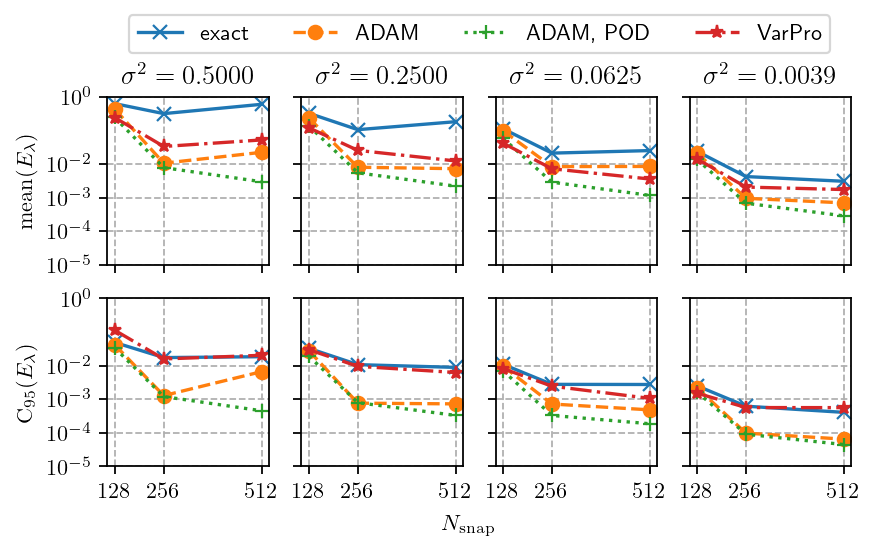

In [17]:
fig, axarr = plt.subplots(2, 4, figsize=(6, 3), sharex=True, sharey=True)

for i, exp in enumerate((1, 2, 4, 8)):
    n_snap, mean, ci, _, _ = extract_statistics(results, exp, "eigs_err_exact")
    axarr[0, i].plot(n_snap, mean, ls="-", label="exact", marker="x")
    axarr[1, i].plot(n_snap, ci, ls="-", label="exact", marker="x")
    n_snap, mean, ci, _, _ = extract_statistics(results, exp, "eigs_err_opt")
    axarr[0, i].plot(n_snap, mean, ls="--", label="ADAM", marker="o")
    axarr[1, i].plot(n_snap, ci, ls="--", label="ADAM", marker="o")
    n_snap, mean, ci, _, _ = extract_statistics(results, exp, "eigs_err_optPro")
    axarr[0, i].plot(n_snap, mean, ls=":", label="ADAM, POD", marker="+")
    axarr[1, i].plot(n_snap, ci, ls=":", label="ADAM, POD", marker="+")
    n_snap, mean, ci, _, _ = extract_statistics(results, exp, "eigs_err_bopt")
    axarr[0, i].plot(n_snap, mean, ls="-.", label="VarPro", marker="*")
    axarr[1, i].plot(n_snap, ci, ls="-.", label="VarPro", marker="*")
    axarr[0, i].set_title(r"$\sigma^2 = {:1.4f}$".format(2**-exp))
for ax in axarr.flatten():
    ax.set_yscale("log")
    ax.set_xticks(n_snap)
    ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1])
    ax.grid(ls="--")
axarr[0, 0].legend(ncol=4, bbox_to_anchor=(2.3, 1.55), loc="upper center")
axarr[0, 0].set_ylabel(r"$\mathrm{mean}(E_{\lambda})$")
axarr[1, 0].set_ylabel(r"$\mathrm{C}_{95}(E_{\lambda})$")
fig.text(0.5, -0.02, r"$N_{\mathrm{snap}}$", ha="center")
plt.savefig(join(results_path, "eigval_error.pdf"), bbox_inches="tight")

## Execution times

Note that the timings are only rough estimates rather than hard benchmarks.
- the times are averaged over 100 runs and 4 noise levels
- the numerical tests were not run on exclusively reserved hardware

[tensor(0.0046), tensor(0.0125), tensor(0.0205)]
[tensor(0.6729), tensor(1.5650), tensor(5.9085)]
[tensor(0.8532), tensor(2.0727), tensor(9.4583)]
[tensor(0.0871), tensor(0.1919), tensor(0.2914)]


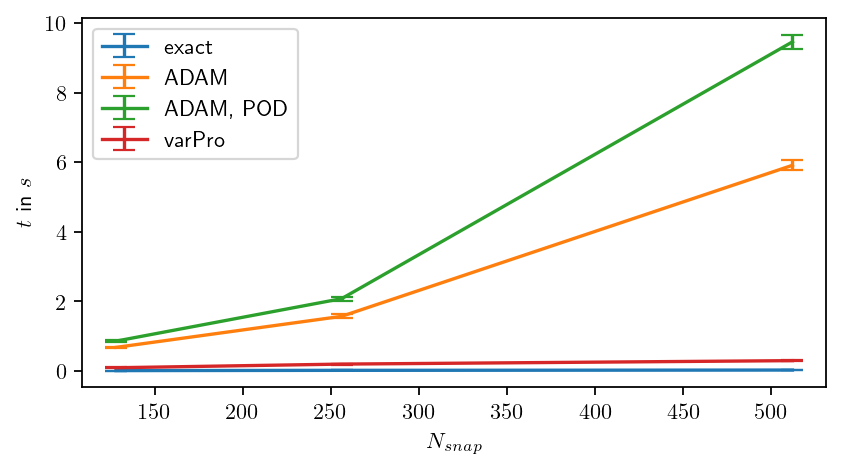

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))
n_snap, mean, std, _, _ = extract_statistics(results, exp, "time_exact")
print(mean)
ax.errorbar(n_snap, mean, std, capsize=5, label="exact")
n_snap, mean, std, _, _ = extract_statistics(results, exp, "time_opt")
print(mean)
ax.errorbar(n_snap, mean, std, capsize=5, label="ADAM")
n_snap, mean, std, _, _ = extract_statistics(results, exp, "time_optPro")
print(mean)
ax.errorbar(n_snap, mean, std, capsize=5, label="ADAM, POD")
n_snap, mean, std, _, _ = extract_statistics(results, exp, "time_bopt")
print(mean)
ax.errorbar(n_snap, mean, std, capsize=5, label="varPro")

ax.set_xlabel(r"$N_{snap}$")
ax.set_ylabel(r"$t$ in $s$")
ax.legend()
plt.show()